In [1]:
# this notebook should be run in jupyter notebook
# I will use the same window size that I used in the BTC-values-model.ipynb file
# matplotlib and seaborn used for plotting graphs

import itertools
import warnings
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from itertools import product
%matplotlib inline

warnings.filterwarnings("ignore")

In [2]:
# you can retrieve BTC data using cryptocompare api as I did
# here I will use already retrieved csv file containing the BTC information of the last 1000 days

df = pd.read_csv("btc.csv", parse_dates = True, index_col=0)
df.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2017-11-06 15:16:30.932203,6959.23,7429.70,6934.73,7389.55,159688.48,1.148125e+09
2017-11-07 15:16:30.932203,7102.75,7222.37,6957.80,6959.27,101044.57,7.167984e+08
2017-11-08 15:16:30.932203,7444.36,7869.10,7026.97,7102.23,220224.38,1.632547e+09
2017-11-09 15:16:30.932203,7129.59,7457.12,7040.83,7444.36,126769.90,9.159639e+08
2017-11-10 15:16:30.932203,6565.80,7318.97,6406.05,7129.59,222001.18,1.513421e+09


In [3]:
# split the time series into two contiguous sequences
# calculate the mean and variance of each group of numbers and compare the values

df.dropna(inplace=True)
X = df.values
split = len(X) // 2
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=124949200.031147, mean2=68733537.503613
variance1=171084450863706592.000000, variance2=39508838031447928.000000


Text(0.5, 0, 'daily average')

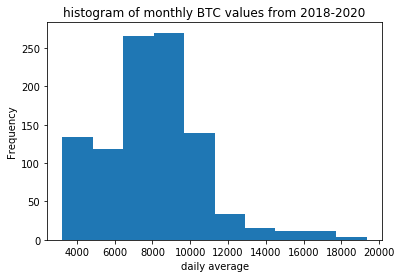

In [4]:
# check if assuming a Gaussian distribution makes sense in this case by plotting 
# the values of the time series as a histogram

df.close.resample('D').mean().plot.hist()          # plot monthy data
plt.title("histogram of monthly BTC values from 2018-2020")
plt.xlabel('daily average')

Text(0.5, 0, 'monthly average')

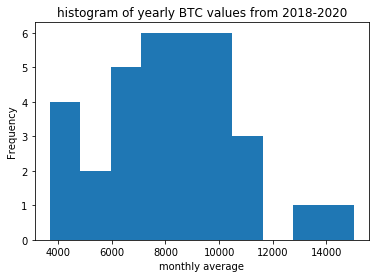

In [5]:
df.close.resample('M').mean().plot.hist()          # plot yearly data
plt.title("histogram of yearly BTC values from 2018-2020")
plt.xlabel("monthly average")

In [6]:
# running the example shows that indeed the distribution of values does not look like a Gaussian one
# therefore the mean and variance values are less meaningful
# this squashed distribution of the observations may be another indicator of a non-stationary time series

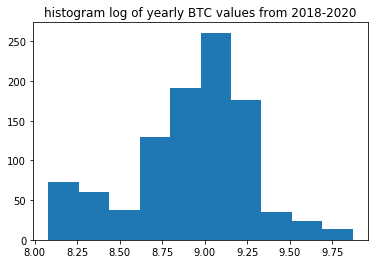

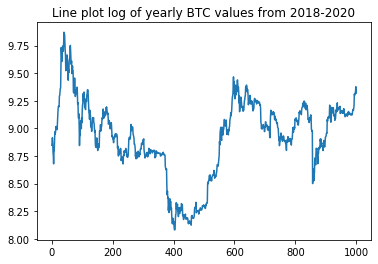

In [7]:
X = df.close.values
X = np.log(X)
plt.hist(X)
plt.title("histogram log of yearly BTC values from 2018-2020")
plt.show()
plt.plot(X)
plt.title("Line plot log of yearly BTC values from 2018-2020")
plt.show()

In [8]:
# mean and standard deviation of the values of the log transformed dataset

X = df.close.values
X = log(X)
split = len(X) // 2
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=8.825794, mean2=9.022697
variance1=0.173600, variance2=0.054518


In [9]:
# running the examples shows mean and standard deviation values for each group that looks similar, but not identical
# perhaps, from these numbers alone, we would say the time series is stationary
# but we strongly believe this to not be the case from reviewing the line plot

In [10]:
# rolling statistics

rolmean = df.close.rolling(window = 7).std()
rolSTD = df.close.rolling(window = 7).std()
print(rolmean, rolSTD)

time
2017-11-06 15:16:30.932203           NaN
2017-11-07 15:16:30.932203           NaN
2017-11-08 15:16:30.932203           NaN
2017-11-09 15:16:30.932203           NaN
2017-11-10 15:16:30.932203           NaN
                                 ...    
2020-07-29 15:16:30.932203    720.663190
2020-07-30 15:16:30.932203    715.581769
2020-07-31 15:16:30.932203    643.358353
2020-08-01 15:16:30.932203    565.966072
2020-08-02 15:16:30.932203    291.977284
Name: close, Length: 1001, dtype: float64 time
2017-11-06 15:16:30.932203           NaN
2017-11-07 15:16:30.932203           NaN
2017-11-08 15:16:30.932203           NaN
2017-11-09 15:16:30.932203           NaN
2017-11-10 15:16:30.932203           NaN
                                 ...    
2020-07-29 15:16:30.932203    720.663190
2020-07-30 15:16:30.932203    715.581769
2020-07-31 15:16:30.932203    643.358353
2020-08-01 15:16:30.932203    565.966072
2020-08-02 15:16:30.932203    291.977284
Name: close, Length: 1001, dtype: float64


Text(0.5, 1.0, 'rolling mean & standard deviation of BTC values')

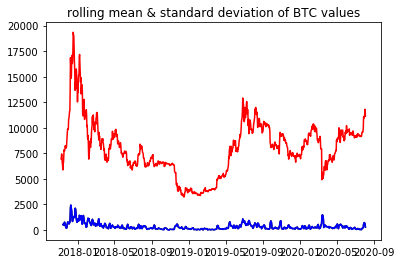

In [11]:
# plot rolling statistic

orig = plt.plot(df.close, color = "red", label = 'original')
mean = plt.plot(rolmean, color = 'black', label = 'rolling Mean')
std = plt.plot(rolSTD, color = 'blue', label = 'rolling std')
plt.title("rolling mean & standard deviation of BTC values")

In [12]:
# perform ADF test

print("Results of Dickey-Fuller Test:")
adftest = adfuller(df.close, autolag = 'AIC')

adfoutput = pd.Series(adftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)' %key] = value
    print(adfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.673775
p-value                          0.078687
#Lags Used                      10.000000
Number of Observations Used    990.000000
Critical Value (1%)             -3.436973
dtype: float64
Test Statistic                  -2.673775
p-value                          0.078687
#Lags Used                      10.000000
Number of Observations Used    990.000000
Critical Value (1%)             -3.436973
Critical Value (5%)             -2.864464
dtype: float64
Test Statistic                  -2.673775
p-value                          0.078687
#Lags Used                      10.000000
Number of Observations Used    990.000000
Critical Value (1%)             -3.436973
Critical Value (5%)             -2.864464
Critical Value (10%)            -2.568327
dtype: float64


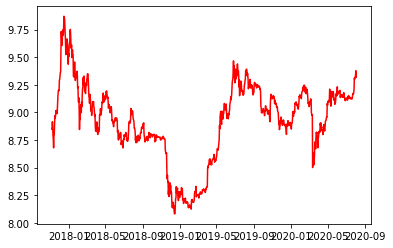

In [13]:
# plot log transformed dataset

df.close_logScale = np.log(df.close)
plt.plot(df.close_logScale, color = 'red')

Text(0.5, 1.0, 'moving average BTC value')

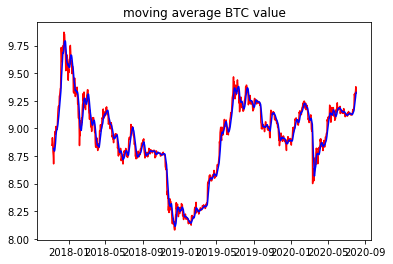

In [14]:
movingAverage = df.close_logScale.rolling(window = 7). mean()
movingSTD = df.close_logScale.rolling(window = 7). std()
plt.plot(df.close_logScale, color = 'red', label = "log data of closing price")
plt.plot(movingAverage, color = 'blue', label = "moving average")
plt.title("moving average BTC value")

In [15]:
datasetlogScaleMinusMovingAverage = df.close_logScale - movingAverage
datasetlogScaleMinusMovingAverage.head(20)

time
2017-11-06 15:16:30.932203         NaN
2017-11-07 15:16:30.932203         NaN
2017-11-08 15:16:30.932203         NaN
2017-11-09 15:16:30.932203         NaN
2017-11-10 15:16:30.932203         NaN
2017-11-11 15:16:30.932203         NaN
2017-11-12 15:16:30.932203   -0.139080
2017-11-13 15:16:30.932203   -0.025809
2017-11-14 15:16:30.932203   -0.003884
2017-11-15 15:16:30.932203    0.098192
2017-11-16 15:16:30.932203    0.159782
2017-11-17 15:16:30.932203    0.117251
2017-11-18 15:16:30.932203    0.098451
2017-11-19 15:16:30.932203    0.086747
2017-11-20 15:16:30.932203    0.078085
2017-11-21 15:16:30.932203    0.031056
2017-11-22 15:16:30.932203    0.029997
2017-11-23 15:16:30.932203   -0.000102
2017-11-24 15:16:30.932203    0.014011
2017-11-25 15:16:30.932203    0.062523
Name: close, dtype: float64

In [16]:
# remove NaN values

datasetlogScaleMinusMovingAverage.dropna(inplace = True)
datasetlogScaleMinusMovingAverage.head(10)

time
2017-11-12 15:16:30.932203   -0.139080
2017-11-13 15:16:30.932203   -0.025809
2017-11-14 15:16:30.932203   -0.003884
2017-11-15 15:16:30.932203    0.098192
2017-11-16 15:16:30.932203    0.159782
2017-11-17 15:16:30.932203    0.117251
2017-11-18 15:16:30.932203    0.098451
2017-11-19 15:16:30.932203    0.086747
2017-11-20 15:16:30.932203    0.078085
2017-11-21 15:16:30.932203    0.031056
Name: close, dtype: float64

In [17]:
def test_stationarity(timeseries):
    
    #determining rolling statistics
    movingAverage = timeseries.rolling(window = 7).mean()
    movingSTD = timeseries.rolling(window = 7).std()
    
    # plot rolling statistic
    orig = plt.plot(timeseries, color = "red", label = 'original')
    mean = plt.plot(movingAverage, color = 'blue', label = 'rolling mean')
    std = plt.plot(movingSTD, color = 'black', label = 'rolling std')
    plt.title("rolling mean & standard deviation of BTC values")
    
    #perform Dickey-Fuller test
    print("results of Dickey-Fuller test:")
    adftest = adfuller(timeseries, autolag = 'AIC')
    adfoutput = pd.Series(adftest[0:4], index = ['test statistic', 'p-value', '# of lags used', '# of observations used'])
    for key,value in adftest[4].items():
        adfoutput['critical value (%s)' %key] = value
    print(adfoutput)

results of Dickey-Fuller test:
test statistic           -1.147938e+01
p-value                   5.038030e-21
# of lags used            3.000000e+00
# of observations used    9.910000e+02
critical value (1%)      -3.436966e+00
critical value (5%)      -2.864461e+00
critical value (10%)     -2.568325e+00
dtype: float64


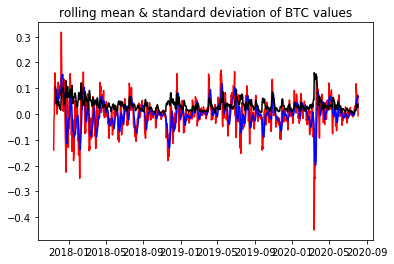

In [18]:
test_stationarity(datasetlogScaleMinusMovingAverage)

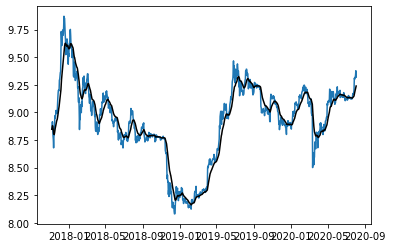

In [19]:
exponentialDecayweightedAverage = df.close_logScale.ewm(halflife = 7, min_periods = 0, adjust = True). mean()
plt.plot(df.close_logScale)
plt.plot(exponentialDecayweightedAverage, color = 'black')                                                  

results of Dickey-Fuller test:
test statistic           -6.391866e+00
p-value                   2.096297e-08
# of lags used            2.000000e+00
# of observations used    9.980000e+02
critical value (1%)      -3.436919e+00
critical value (5%)      -2.864440e+00
critical value (10%)     -2.568314e+00
dtype: float64


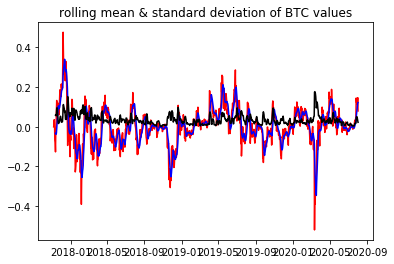

In [20]:
datasetlogScaleMinusMovingExponentialDecayAverage = df.close_logScale - exponentialDecayweightedAverage
test_stationarity(datasetlogScaleMinusMovingExponentialDecayAverage)

Text(0.5, 1.0, 'shifted logscale values to time series')

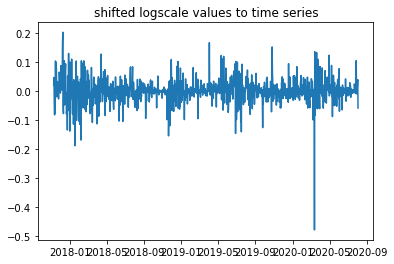

In [21]:
datasetLogDiffShifting = df.close_logScale - df.close_logScale.shift()
plt.plot(datasetLogDiffShifting)
plt.title("shifted logscale values to time series")

results of Dickey-Fuller test:
test statistic           -8.877944e+00
p-value                   1.342026e-14
# of lags used            2.000000e+01
# of observations used    9.500000e+02
critical value (1%)      -3.437252e+00
critical value (5%)      -2.864587e+00
critical value (10%)     -2.568392e+00
dtype: float64


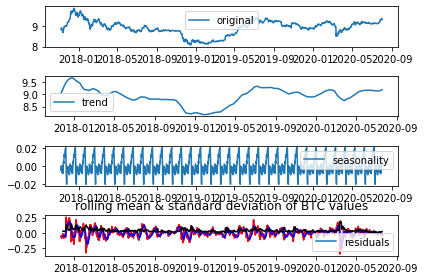

In [22]:
# you can set frequency to different values

decomposition = seasonal_decompose(df.close_logScale, freq = 30)
trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid

plt.subplot(411) 
plt.plot(df.close_logScale, label = 'original') 
plt.legend(loc = 'best') 
plt.subplot(412) 
plt.plot(trend, label = 'trend') 
plt.legend(loc = 'best') 
plt.subplot(413) 
plt.plot(seasonal, label = 'seasonality') 
plt.legend(loc = 'best') 
plt.subplot(414) 
plt.plot(residual, label = 'residuals') 
plt.legend(loc = 'best') 
plt.tight_layout()

decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

results of Dickey-Fuller test:
test statistic           -8.877944e+00
p-value                   1.342026e-14
# of lags used            2.000000e+01
# of observations used    9.500000e+02
critical value (1%)      -3.437252e+00
critical value (5%)      -2.864587e+00
critical value (10%)     -2.568392e+00
dtype: float64


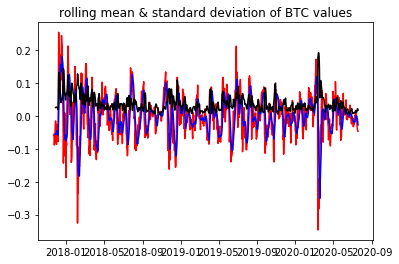

In [23]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

In [24]:
# remove NaN values

datasetLogDiffShifting.dropna(inplace = True)
datasetLogDiffShifting.head(10)

time
2017-11-07 15:16:30.932203    0.020413
2017-11-08 15:16:30.932203    0.046975
2017-11-09 15:16:30.932203   -0.043203
2017-11-10 15:16:30.932203   -0.082379
2017-11-11 15:16:30.932203   -0.035018
2017-11-12 15:16:30.932203   -0.075618
2017-11-13 15:16:30.932203    0.104011
2017-11-14 15:16:30.932203    0.011374
2017-11-15 15:16:30.932203    0.098949
2017-11-16 15:16:30.932203    0.075409
Name: close, dtype: float64

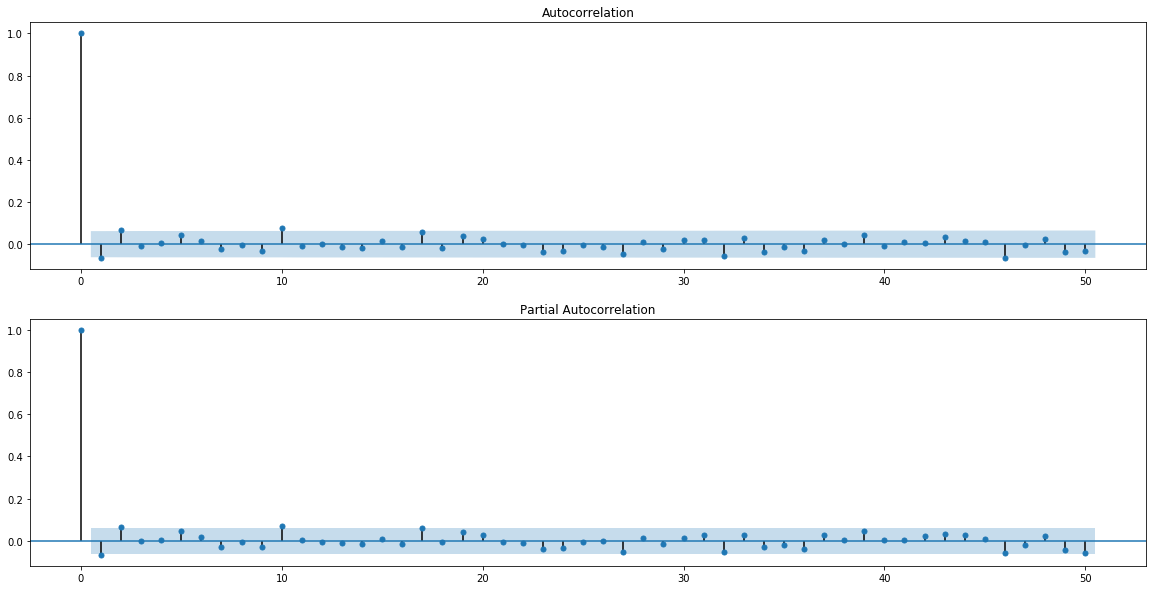

In [25]:
# Autocorrelogram (ACF graph) & Partail Autocorrelogram (PACF graph) is useful to estimate model's parametaers

fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(datasetLogDiffShifting.dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(datasetLogDiffShifting.dropna(), lags=50, ax=ax[1])
plt.show()

In [26]:
# plots above indicate that 10th lag is significant
# make a grid search with maximum AR and MA are 10 and 10 respectively :) to determine "p" and "q" hyperparameters

resDiff = sm.tsa.arma_order_select_ic(df.close, max_ar=10, max_ma=10, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (9, 9) is the best.


plotting AR Model


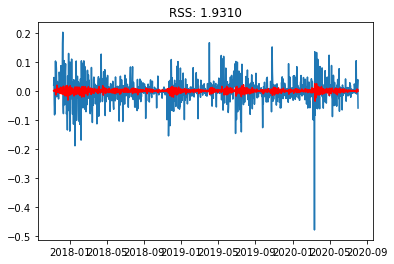

In [27]:
# AR model

model = ARIMA(df.close_logScale, order = (9, 1, 9))
results_AR = model.fit(disp = -1, transparams=False, enforce_stationary=False)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color = 'red')
plt.title("RSS: %.4f" % sum((results_AR.fittedvalues - datasetLogDiffShifting)**2))
print('plotting AR Model')

plotting MA Model


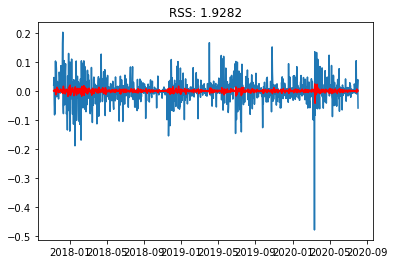

In [28]:
# MA model

model= ARIMA(df.close_logScale, order = (9, 1, 0))
results_MA = model.fit(disp = -1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color = 'red')
plt.title("RSS: %.4f" % sum((results_MA.fittedvalues - datasetLogDiffShifting)**2))
print('plotting MA Model')

plotting ARIMA Model


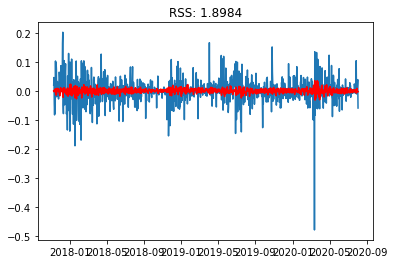

In [29]:
# the model

model= ARIMA(df.close_logScale, order = (9, 1, 9))
results_ARIMA = model.fit(disp = -1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color = 'red')
plt.title("RSS: %.4f" % sum((results_ARIMA.fittedvalues - datasetLogDiffShifting)**2))
print('plotting ARIMA Model')

In [30]:
# ARIMA results

predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy = True)
predictions_ARIMA_diff.head()

time
2017-11-07 15:16:30.932203    0.000310
2017-11-08 15:16:30.932203   -0.001326
2017-11-09 15:16:30.932203   -0.002592
2017-11-10 15:16:30.932203    0.005130
2017-11-11 15:16:30.932203    0.004884
dtype: float64

In [31]:
# convert to cumulative sum

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

time
2017-11-07 15:16:30.932203    0.000310
2017-11-08 15:16:30.932203   -0.001016
2017-11-09 15:16:30.932203   -0.003608
2017-11-10 15:16:30.932203    0.001522
2017-11-11 15:16:30.932203    0.006406
dtype: float64

In [32]:
# new reaults

predictions_ARIMA_log = pd.Series(df.close_logScale.iloc[0], index = df.close_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

time
2017-11-06 15:16:30.932203    8.847824
2017-11-07 15:16:30.932203    8.848135
2017-11-08 15:16:30.932203    8.846808
2017-11-09 15:16:30.932203    8.844216
2017-11-10 15:16:30.932203    8.849347
dtype: float64

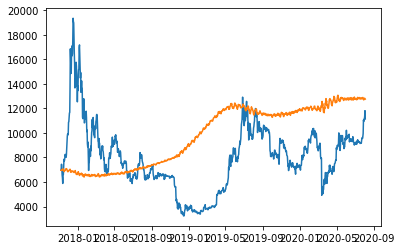

In [33]:
# see if the model fits the actual data

predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df.close)
plt.plot(predictions_ARIMA)

In [34]:
df.close_logScale.head()

time
2017-11-06 15:16:30.932203    8.847824
2017-11-07 15:16:30.932203    8.868237
2017-11-08 15:16:30.932203    8.915212
2017-11-09 15:16:30.932203    8.872009
2017-11-10 15:16:30.932203    8.789630
Name: close, dtype: float64

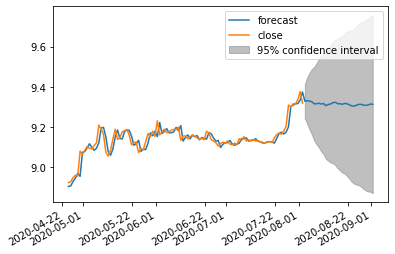

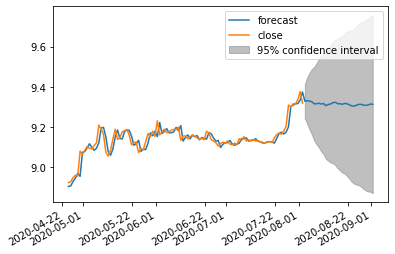

In [35]:
# plot previous 100 days and next 30 days

results_ARIMA.plot_predict(900, 1030)

In [36]:
# check out the predicted values for the next 30 days

month_forecast = np.exp(results_ARIMA.forecast(steps=30)[0])
i = 0
for i in range(len(month_forecast)):
    print('day ' + str(i+1) + '       ' + str(month_forecast[i]))
    i += 1

day 1       11256.324079727834
day 2       11287.106705703121
day 3       11260.323965582027
day 4       11224.793439798024
day 5       11111.818851729371
day 6       11113.270807132485
day 7       11142.416871634265
day 8       11100.10386824931
day 9       11125.115610926207
day 10       11009.296272495974
day 11       11075.78878201568
day 12       11102.60667492054
day 13       11175.084285183179
day 14       11197.345274842603
day 15       11118.504662966132
day 16       11116.185682360268
day 17       11083.024771090326
day 18       11138.024673471955
day 19       11109.848727531971
day 20       11062.88260699279
day 21       10992.240290335556
day 22       10985.323468985973
day 23       11029.857383550798
day 24       11079.821032111198
day 25       11082.921691189304
day 26       11039.785331982674
day 27       11029.333332496619
day 28       11042.5637388501
day 29       11101.673924823343
day 30       11085.54575988766
